# Python Package Setup

In [31]:
print('⏳ Installing packages')
%pip install -q pillow jupyter openai brave-search wolframalpha
print('✅ Packages installed')

⏳ Installing packages
Note: you may need to restart the kernel to use updated packages.
✅ Packages installed


# OctoAI Setup

OctoAI provides inference endpoints to the best and latest open source LLMs out there, including Meta's newly released Llama3.1 models:
* meta-llama-3.1-8b-instruct
* meta-llama-3.1-70b-instruct
* meta-llama-3.1-405b-instruct

For the examples below, we'll use the 70b model variant.

Create an account on [OctoAI](https://octoai.cloud/) via your Google account or GitHub account, and create an OctoAI token that we'll enter below.

If you're creating an account for the first time, you'll be given $10, which gives you lots of LLM usage to start your OctoAI journey with. You can find out more about LLM pricing [here](https://octo.ai/docs/getting-started/pricing-and-billing#text-gen-solution)

In [32]:
import getpass
import os

os.environ["OCTOAI_API_KEY"] = getpass.getpass()

## OctoAI test

Let's run the cell below to ensure we're all properly set up.

In [33]:
from openai import OpenAI
import json

client = OpenAI(
    base_url="https://text.octoai.run/v1",
    api_key=os.environ["OCTOAI_API_KEY"]
)

model = "meta-llama-3.1-405b-instruct"

completion = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "user", "content": "Hello!"},
    ]
)

print(completion.choices[0].message)

ChatCompletionMessage(content="Hello! It's nice to meet you. Is there something I can help you with or would you like to chat?", refusal=None, role='assistant', function_call=None, tool_calls=None)


# Wolfram and Brave Search Setup

In this notebook you'll need to use two external tools: Wolfram Alpha and Brave Search. You can get set up by following the links below and obtaining the API keys to drive the examples we'll look into next.

Generate a Wolfram App ID for the simple API here on it's [developer portal](https://developer.wolframalpha.com/)

Generate a Brave Search API key on the [Search API dashboard](https://api.search.brave.com/login)

In [34]:
os.environ["BRAVE_API_KEY"] = getpass.getpass()

In [35]:
os.environ["WOLFRAM_APP_ID"] = getpass.getpass()

# LLM Limitations

LLMs have several widely known limitations:
* They are very limited at resolving mathematical questions on their own (e.g. "I just got a 25 year mortgage of 400k at a fixed rate of 5.14% and paid 20% down. How much will I pay in interest?")
* The parametric memory of an LLM is limited to the data it sees at training time. When asked about recent events, LLMs on their own won't be able to answer the question or even worse, end up hallucinating the answer (e.g. "What caused severe airlines industry disruptions in July of 2024"?)

In [36]:
# Example of limitation #1
# The model is hallucinating the result which is bad because it is answering so confidently.
completion = client.chat.completions.create(
  model=model,
  messages=[
    {"role": "user", "content": "I just got a 25 year mortgage of 400k at a fixed rate of 5.14% and paid 20% down. How much will I pay in interest?"}
  ]
)

print(completion.choices[0].message)

ChatCompletionMessage(content="To calculate the total interest paid over the life of the mortgage, we'll use a mortgage calculator or create a formula. \n\nFirst, let's determine the loan amount:\nThe purchase price is $400,000, and you paid 20% down, which is $80,000. The loan amount is $400,000 - $80,000 = $320,000.\n\nNow, let's use a mortgage formula or calculator to determine the monthly payment and total interest paid:\n\nMonthly Payment ≈ $1,822.41\n\nOver 25 years, the total interest paid will be approximately:\n\nTotal Interest ≈ $223,401.89\n\nSo, in addition to the loan amount of $320,000, you'll pay approximately $223,401.89 in interest over the 25-year term, making the total cost of the mortgage around $543,401.89.", refusal=None, role='assistant', function_call=None, tool_calls=None)


In [37]:
# Example of limitation #2
# The model is unable to answer a question on an event that post-dates its training data.
completion = client.chat.completions.create(
  model=model,
  messages=[
    {"role": "user", "content": "What caused severe airlines industry disruptions in July of 2024"}
  ]
)

print(completion.choices[0].message)

ChatCompletionMessage(content='I do not have information on airline industry disruptions in July 2024.', refusal=None, role='assistant', function_call=None, tool_calls=None)


## Tools to the Rescue!

Thankfully Llama3.1 has built-in tool calling capabilities for 3 very handy external tools:
* Python interpreter which helps us run arbitrary Python code to help answer some questions that LLMs cannot answer on their own (e.g. questions that require advanced mathematical reasoning)
* Web search which greatly expands the LLM's ability to access information on recent and live events
* Wolfram Alpha which lets the LLM run queries across many topics including Mathematics, Science&Technology, Society and Culture, and Every Day life

Together these three built-in tools vastly expand the LLM's ability to provide helpful answers as we'll see in the examples below.

In [38]:
# Required for python interpreter
import sys
from io import StringIO
import contextlib
# Required for Brave Search
from brave import Brave
# Required for Wolfram Alpha
from wolframalpha import Client
import nest_asyncio

# Need to run this for Wolfram client lib
nest_asyncio.apply()

# Helper for code interpreter
@contextlib.contextmanager
def stdoutIO(stdout=None):
    old = sys.stdout
    if stdout is None:
        stdout = StringIO()
    sys.stdout = stdout
    yield stdout
    sys.stdout = old

# Code interpreter definition
def code_interpreter(code: str) -> str:
    with stdoutIO() as s:
        exec("{}".format(code))
    return s.getvalue()

# Brave search definition
def brave_search(query: str) -> str:
    brave = Brave(os.environ["BRAVE_API_KEY"])
    results = brave.search(q=query, count=10)
    return str(results)

# Wolfram Alpha definition
def wolfram_alpha(query: str) -> str:
    client = Client(os.environ["WOLFRAM_APP_ID"])
    return str(client.query(query))

# Names to functions dictionary to get tools response
names_to_functions = {
    "code_interpreter": code_interpreter,
    "brave_search": brave_search,
    "wolfram_alpha": wolfram_alpha
}

# Brave Search

Brave search is excellent for providing context to the LLM on recent events, or real time information (e.g. weather).

In [39]:
messages=[
    {
        "role": "system",
        "content": "You are a helpful assistant."
    },
    {
        "role": "user",
        "content": "What caused severe airlines industry disruptions in July of 2024?"
    }
]

# First LLM inference
completion = client.chat.completions.create(
    model=model,
    messages=messages,
    temperature=0,
    tools=[{"type": "function", "function": {"name": "brave_search"}}],
    tool_choice="auto",
)

# Append the assistant response to messages
assistant_response = completion.choices[0].message
messages.append(
    {
        "role": "assistant",
        "content": "",
        "tool_calls": completion.choices[0].message.tool_calls
    }
)

print(completion.choices[0].message)

ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_UZD4vds87GTEgHDgr66tsS64', function=Function(arguments='{"query": "severe airline industry disruptions July 2024"}', name='brave_search'), type='function')])


In [40]:
# Derive the tool call information
tool_call = completion.choices[0].message.tool_calls[0]
function_name = tool_call.function.name
function_params = json.loads(tool_call.function.arguments)

# Compute the results
function_result = names_to_functions[function_name](**function_params)

# Append to the tools response
messages.append(
    {
        "role": "tool",
        "content": function_result
    }
)

In [41]:
# Formulate the final LLM answer based on the provided context
completion = client.chat.completions.create(
    model=model,
    messages=messages,
    temperature=0,
    tools=[{"type": "function", "function": {"name": "brave_search"}}],
    tool_choice="auto",
)

print(completion.choices[0].message.content)

The severe airline industry disruptions in July 2024 were caused by a global tech outage that affected multiple airlines, airports, and businesses worldwide. The outage was caused by a botched software update from cybersecurity firm CrowdStrike Holdings Inc. that crashed countless Microsoft Windows computer systems around the world. This led to flight cancellations, delays, and disruptions in air travel operations.


# Python Interpreter

Python interpreter is great for solving complex mathematical or coding challenges.

In [42]:
messages=[
    {
        "role": "system",
        "content": "You are a personal math tutor. When asked a math question, write and run code to answer the question."
    },
    {
        "role": "user",
        "content": "I just got a 25 year mortgage of 400k at a fixed rate of 5.14% and paid 20% down. How much will I pay in interest?"
    }
]

# First LLM inference
completion = client.chat.completions.create(
    model=model,
    messages=messages,
    temperature=0,
    tools=[{"type": "function", "function": {"name": "code_interpreter"}}],
    tool_choice="auto",
)

# Append the assistant response to messages
assistant_response = completion.choices[0].message
messages.append(
    {
        "role": "assistant",
        "content": "",
        "tool_calls": completion.choices[0].message.tool_calls
    }
)

print(json.loads(completion.choices[0].message.tool_calls[0].function.arguments)["code"])

def calculate_interest(principal, rate, years):
    # Convert rate from percentage to a fraction
    rate = rate / 100
    # Calculate monthly rate
    monthly_rate = rate / 12
    # Calculate number of payments
    num_payments = years * 12
    # Calculate monthly payment
    monthly_payment = principal * monthly_rate * (1 + monthly_rate) ** num_payments / ((1 + monthly_rate) ** num_payments - 1)
    # Calculate total interest
    total_interest = monthly_payment * num_payments - principal
    return total_interest

# Input values
principal = 400000 * .8  # 20% down payment
rate = 5.14
years = 25

# Calculate and print the total interest
total_interest = calculate_interest(principal, rate, years)
print(f'The total interest paid over the life of the mortgage is: ${total_interest:.2f}')


In [43]:
# Derive the tool call information
tool_call = completion.choices[0].message.tool_calls[0]
function_name = tool_call.function.name
function_params = json.loads(tool_call.function.arguments)

# Compute the results
function_result = names_to_functions[function_name](**function_params)
print(function_result)

# Append to the tools response
messages.append(
    {
        "role": "tool",
        "content": function_result
    }
)

The total interest paid over the life of the mortgage is: $249064.70



In [44]:
# Formulate the final LLM answer based on the provided context
completion = client.chat.completions.create(
    model=model,
    messages=messages,
    temperature=0,
    tools=[{"type": "function", "function": {"name": "code_interpreter"}}],
    tool_choice="auto",
)

print(completion.choices[0].message.content)

The total interest paid over the life of the mortgage is: $249064.70


# Wolfram alpha

Wolfram alpha is a great tool for answering even more challenging mathematical or scientific questions that the python interpreter would perform poorly on.

In [45]:
messages=[
    {
        "role": "system",
        "content": "You are a helpful assistant. Use the wolfram_alpha tool for all user queries."
    },
    {
        "role": "user",
        "content": "What are the poles of (z^2-4) / ((z-2)^4*(z^2+5z+7))"
    }
]

# First LLM inference
completion = client.chat.completions.create(
    model=model,
    messages=messages,
    temperature=0,
    tools=[{"type": "function", "function": {"name": "wolfram_alpha"}}],
    tool_choice="auto",
)

# Append the assistant response to messages
assistant_response = completion.choices[0].message
messages.append(
    {
        "role": "assistant",
        "content": "",
        "tool_calls": completion.choices[0].message.tool_calls
    }
)

print(completion.choices[0].message)

ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_EN089HUZljef3tEKtfDnE6gn', function=Function(arguments='{"query": "poles of (z^2-4) / ((z-2)^4*(z^2+5z+7))"}', name='wolfram_alpha'), type='function')])


In [46]:
# Derive the tool call information
tool_call = completion.choices[0].message.tool_calls[0]
function_name = tool_call.function.name
function_params = json.loads(tool_call.function.arguments)

# Compute the results
function_result = names_to_functions[function_name](**function_params)

# Append to the tools response
messages.append(
    {
        "role": "tool",
        "content": function_result
    }
)

In [47]:
# Formulate the final LLM answer based on the provided context
completion = client.chat.completions.create(
    model=model,
    messages=messages,
    temperature=0,
    tools=[{"type": "function", "function": {"name": "wolfram_alpha"}}],
    tool_choice="auto",
)

print(completion.choices[0].message.content)

The poles of the function (z^2-4) / ((z-2)^4*(z^2+5z+7)) are:

* z = 2 (order 3 pole)
* z = 1/2 (-5 - i sqrt(3)) (simple pole)
* z = 1/2 (-5 + i sqrt(3)) (simple pole)

The zero of the function is:

* z = -2 (simple zero)

The residues of the function at the poles are:

* Res_(z = 2)((z^2 - 4)/((z - 2)^4 (z^2 + 5 z + 7))) = 17/3087
* Res_(z = 1/2 (-5 - i sqrt(3)))((z^2 - 4)/((z - 2)^4 (z^2 + 5 z + 7))) = (-sqrt(3) + i)/(162 sqrt(3) + 180 i)
* Res_(z = 1/2 (-5 + i sqrt(3)))((z^2 - 4)/((z - 2)^4 (z^2 + 5 z + 7))) = (4 i (sqrt(3) + i))/(sqrt(3) (sqrt(3) + 9 i)^3)

The pole-zero plot of the function is also provided.


# Generic function calling

Additionally Llama3.1 excels at function calling as well! See the example below on how one may want to use Llama3.1 to invoke generic external tools.

In [48]:
# Mock function to simulate getting flight status
def get_flight_status(flight_number, date):
    return json.dumps({"flight_number": flight_number, "status": "On Time", "date": date})

# Define the function and its parameters to be available for the model
tools = [
  {
    "type": "function",
    "function": {
      "name": "get_flight_status",
      "description": "Get the current status of a flight",
      "parameters": {
        "type": "object",
        "properties": {
          "flight_number": {
            "type": "string",
            "description": "The flight number, e.g., AA100"
          },
          "date": {
            "type": "string",
            "format": "date",
            "description": "The date of the flight, e.g., 2024-06-17"
          }
        },
        "required": ["flight_number", "date"]
      }
    }
  }
]

# Initial conversation setup with the system and user roles
messages = [
    {"role": "system", "content": "You are a helpful assistant that can help with flight information and status."},
    {"role": "user", "content": "I have a flight booked for tomorrow with American Airlines, flight number AA100. Can you check its status for me?"}
]

# Create a chat completion request with the model, messages, and the tools available to the model
response = client.chat.completions.create(
    model=model,
    messages=messages,
    tools=tools,
    tool_choice="auto",
    temperature=0
)

# Extract the agent's response from the API response
agent_response = response.choices[0].message

# Append the response from the model to keep state in the conversation
messages.append(
    {
        "role": agent_response.role,
        "content": "",
        "tool_calls": [
            tool_call.model_dump()
            for tool_call in response.choices[0].message.tool_calls
        ]
    }
)

# Process any tool calls made by the model
tool_calls = response.choices[0].message.tool_calls
if tool_calls:
    for tool_call in tool_calls:
        function_name = tool_call.function.name
        function_args = json.loads(tool_call.function.arguments)

        # Call the function to get the response
        function_response = locals()[function_name](**function_args)

        # Add the function response to the messages block
        messages.append(
            {
                "tool_call_id": tool_call.id,
                "role": "tool",
                "name": function_name,
                "content": function_response,
            }
        )

    # Pass the updated messages to the model to get the final enriched response
    function_enriched_response = client.chat.completions.create(
        model=model,
        messages=messages,
        tools=tools,
        tool_choice="auto",
    )
    print(completion.choices[0].message.content)

The poles of the function (z^2-4) / ((z-2)^4*(z^2+5z+7)) are:

* z = 2 (order 3 pole)
* z = 1/2 (-5 - i sqrt(3)) (simple pole)
* z = 1/2 (-5 + i sqrt(3)) (simple pole)

The zero of the function is:

* z = -2 (simple zero)

The residues of the function at the poles are:

* Res_(z = 2)((z^2 - 4)/((z - 2)^4 (z^2 + 5 z + 7))) = 17/3087
* Res_(z = 1/2 (-5 - i sqrt(3)))((z^2 - 4)/((z - 2)^4 (z^2 + 5 z + 7))) = (-sqrt(3) + i)/(162 sqrt(3) + 180 i)
* Res_(z = 1/2 (-5 + i sqrt(3)))((z^2 - 4)/((z - 2)^4 (z^2 + 5 z + 7))) = (4 i (sqrt(3) + i))/(sqrt(3) (sqrt(3) + 9 i)^3)

The pole-zero plot of the function is also provided.


# Bonus: PhotoGen

Let's see how we can use the function capability to use an LLM to generate an Image with OctoAI.

In [49]:
import requests
import base64
from PIL import Image

# Let's define the photogen function that uses OctoAI image generation service to generate an image
def photogen(query: str) -> str:
    url = "https://image.octoai.run/generate/sdxl"

    headers = {
        "Authorization": "Bearer {}".format(os.environ["OCTOAI_API_KEY"]),
        "Content-Type": "application/json",
    }

    # Define the data payload
    data = {
        "prompt": f"A beautiful image of {query}",
        "checkpoint": "octoai:lightning_sdxl",
        "width": 1024,
        "height": 1024,
        "num_images": 1,
        "sampler": "DPM_PLUS_PLUS_SDE_KARRAS",
        "steps": 8,
        "cfg_scale": 3,
        "use_refiner": False,
        "style_preset": "base",
    }

    # Send the POST request
    response = requests.post(url, headers=headers, data=json.dumps(data))

    # Parse the JSON response
    response_json = response.json()
    image_b64 = response_json["images"][0]["image_b64"]

    # Decode the base64 image and save it to a file
    image_data = base64.b64decode(image_b64)

    # write image to disk
    filename = "result.jpg"
    with open(filename, "wb") as f:
        f.write(image_data)

    return filename

# Update our function dictionary
names_to_functions["photogen"] = photogen

In [51]:
messages=[
    {
        "role": "system",
        "content": "You are a personal assistant with image generation capabilities."
    },
    {
        "role": "user",
        "content": "Generate a photo of a pink gift box on top of a table in a swiss cafe."
    }
]

# First LLM inference
completion = client.chat.completions.create(
    model=model,
    messages=messages,
    temperature=0,
    tools=[{"type": "function", "function": {"name": "photogen"}}],
    tool_choice="auto",
)

# Append the assistant response to messages
assistant_response = completion.choices[0].message
messages.append(
    {
        "role": "assistant",
        "content": "",
        "tool_calls": completion.choices[0].message.tool_calls
    }
)

print(json.loads(completion.choices[0].message.tool_calls[0].function.arguments)["query"])

a pink gift box on top of a table in a Swiss cafe


In [52]:
# Derive the tool call information
tool_call = completion.choices[0].message.tool_calls[0]
function_name = tool_call.function.name
function_params = json.loads(tool_call.function.arguments)

# Compute the results
function_result = names_to_functions[function_name](**function_params)
print(function_result)

# Append to the tools response
messages.append(
    {
        "role": "tool",
        "content": function_result
    }
)

result.jpg


I hope you enjoyed the Swiss cafe image. Is there anything else you'd like to see?


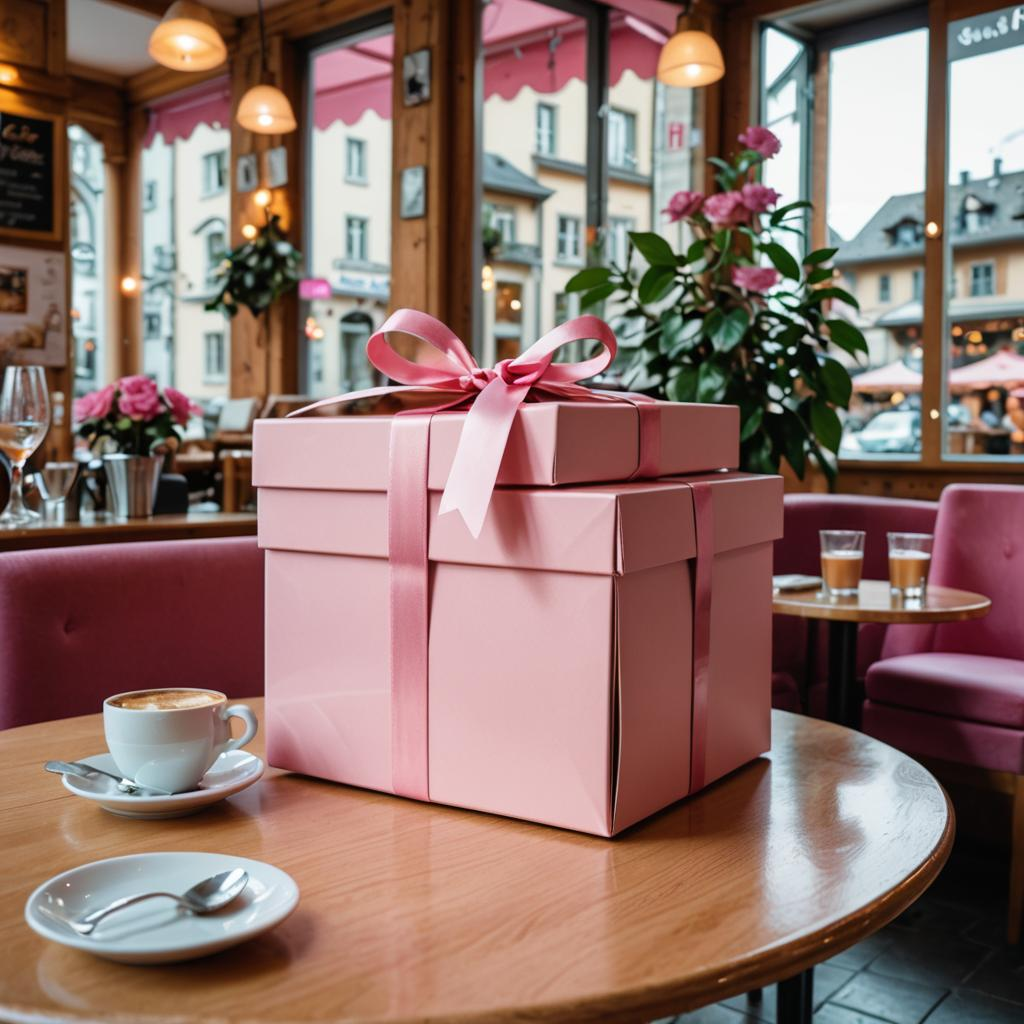

In [53]:
# Formulate the final LLM answer based on the provided context
completion = client.chat.completions.create(
  model=model,
  messages=messages,
  temperature=0,
  tools=[{"type": "function", "function": {"name": "photogen"}}]
)

print(completion.choices[0].message.content)

# Display image stored in the file path given by function_result
from PIL import Image
Image.open(function_result)